<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_Initial_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
# Imports
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# load data
import scipy.io
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'
FILE_PATH = BASE_DIR + 'colloc_Precipflag_DPR_GMI_20170606.sav'
data = scipy.io.readsav(FILE_PATH, verbose=1)

--------------------------------------------------
Date: Fri Jun 26 14:43:54 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------


* *nch* = 13 (number of channels. For channel frequency:
https://www.star.nesdis.noaa.gov/mirs/gpmgmi.php)
* *nfov* = 221 
* *nrec*: number of sweep scans for each particular day

## Variables

* **Emis**: surface emissivity, [no unit], dimension [nch*nfov *nrec]. Valid value: 0<Emis<1
* **Emis_std**: standard deviation of surface emissivity, same dimension with Emis; can be used as a quality-control for "Emis". If Emis_std is large relative to Emis value, that indicates the emissivity data might be of doubtable quality.
* **Tysfc**: surface type. Integer number, each number represents one type of surface (e.g., 1 is ocean). The value of this number has no physical meaning. Rather, it should be served as a classifier for surface. Dimension [nfov * nrec], valid value: 1,2,3, ...,13,14
* **Latc/lonc**: latitude/longitude. Unit is [degree], dimension [nfov * nrec].
* **UTC**: universal time in [hr] unit. Dimension is [nrec]. UTC is the same for each sweep (i.e., nfov).
* **Ts**: surface skin temperature. Unit [K]. dimension [nfov * nrec]. This number is only positive over land. 
* **TWV**: total column water vapor. Unit [??], dimension [nfov * nrec], valid value: [0,100]
* **CLWP**: cloud liquid water path. Unit [kg/m^2], dimension [nfov * nrec], valid value: [0, 12]
* **Tc**: brightness temperature. Unit [K], dimension [nch * nfov * nrec]. Valid value: [50-350]. This is the most important input that are purely from observations. We will try to see if we can solely rely on this variable and of course latitude/longitude/time/season for the precipitation flag prediction. 
* **PFlag**: flag of the type of precipitation. Dimension [nfov * nrec], valid value [0,1,2,3], where 0 is no precipitation, 1 is stratiform, 2 is convective and 3 is other precipitation. 


In [4]:
for var, arr in data.items():
  print(f"{var}: {arr.shape}")

tc: (44425, 221, 13)
latc: (44425, 221)
lonc: (44425, 221)
utc: (44425,)
emis: (44425, 221, 13)
emis_std: (44425, 221, 13)
ts: (44425, 221)
clwp: (44425, 221)
twv: (44425, 221)
tysfc: (44425, 221)
pflag: (44425, 221)


In [5]:
def add_to_PD(freq, ind1, ind2):
  PD[freq] = data['tc'][:, :, ind1] - data['tc'][:, :, ind2]

PD = {}
add_to_PD('10.65', 0, 1)
add_to_PD('18.70', 2, 3)
add_to_PD('36.50', 5, 6)
add_to_PD('89.00', 7, 8)
add_to_PD('166.0', 9, 10)
print(PD.keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


In [6]:
PD['10.65'].shape

(44425, 221)

In [7]:
PD['10.65']

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [64.97    , 63.769997, 61.629997, ..., 20.910004, 20.850006,
        21.919998],
       [65.979996, 64.84999 , 64.65    , ..., 21.11    , 19.869995,
        20.12999 ],
       ...,
       [42.309998, 40.509995, 41.880005, ..., 27.87999 , 29.769989,
        31.40001 ],
       [38.030014, 40.869995, 39.770004, ..., 32.34001 , 31.929993,
        31.690002],
       [38.869995, 38.839996, 38.929993, ..., 32.86    , 29.86    ,
        31.850006]], dtype=float32)

## Code for Plotting Histograms

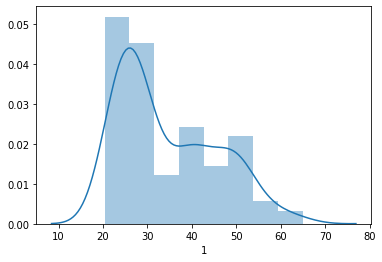

In [8]:
# histogram with seaborn
dataframe = pd.DataFrame.from_records(PD['10.65'])  # num_sweep_scans * num_fields_of_view
sns.distplot(dataframe.iloc[1, :])

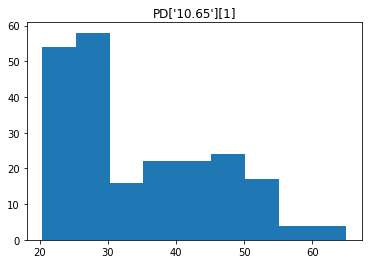

In [9]:
# histogram with matplotlib.pyplot
plt.hist(PD['10.65'][1], bins='auto')
plt.title("PD['10.65'][1]")
plt.show()

# Plot PD Distributions for each pflag

In [10]:
all_unique = set()
for i in range(data['pflag'].shape[0]):
  unique, counts = np.unique(data['pflag'][i, :][~np.isnan(data['pflag'][i, :])], return_counts=True)
  # unique, counts = np.unique(data['pflag'][i, :], return_counts=True)
  # print(dict(zip(unique, counts)))
  all_unique = set.union(all_unique, unique)
print(all_unique)

{0.0, 1.0, 2.0, 3.0, -99.0}


In [11]:
# boolean masks
no_precip = (data['pflag'] == 0.0)
stratiform = (data['pflag'] == 1.0)
convective = (data['pflag'] == 2.0)
other = (data['pflag'] == 3.0)

In [12]:
print(PD['10.65'].ravel().shape)
print(PD['10.65'][no_precip].shape)
print(PD['10.65'][stratiform].shape)
print(PD['10.65'][convective].shape)
print(PD['10.65'][other].shape)

(9817925,)
(1819574,)
(78360,)
(11508,)
(4896,)


## Plots

In [13]:
pd_freqs = ['10.65', '18.70', '36.50', '89.00', '166.0']

In [14]:
def plot_pd_per_pflag(freq, title=None, plot_no_precip=False, plot_other=False, hist=False, save=False):
  sns.distplot(PD[freq][stratiform], hist=hist, label='stratiform')
  sns.distplot(PD[freq][convective], hist=hist, label='convective')
  if plot_no_precip:
    sns.distplot(PD[freq][no_precip], hist=hist, label='no precipitation')
  if plot_other:
    sns.distplot(PD[freq][other], hist=hist, label='other')
  plt.legend()
  plt.title(title)
  if save:
    save_path = BASE_DIR + "plots/"
    if not os.path.exists(save_path):
      os.mkdir(save_path)
    print('Saved to', save_path + f"{title}.png")
    plt.savefig(save_path + f"{title}.png")

Saved to /content/drive/My Drive/data/NASA_2020/plots/PD_10.65_GHz.png


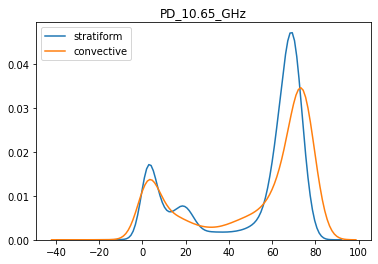

In [15]:
i = 0
plot_pd_per_pflag(pd_freqs[i], title=f'PD_{pd_freqs[i]}_GHz', save=True)

Saved to /content/drive/My Drive/data/NASA_2020/plots/PD_18.70_GHz.png


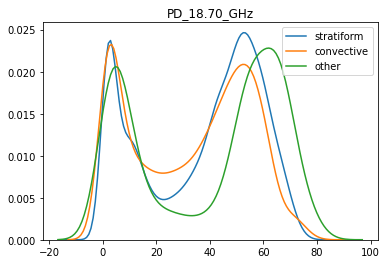

In [16]:
i = 1
plot_pd_per_pflag(pd_freqs[i], title=f'PD_{pd_freqs[i]}_GHz', plot_other=True, save=True)

Saved to /content/drive/My Drive/data/NASA_2020/plots/PD_36.50_GHz.png


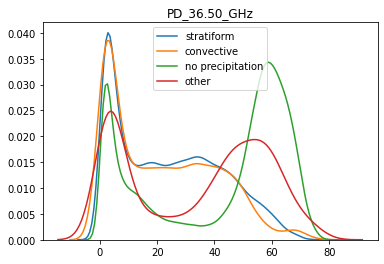

In [17]:
i = 2
plot_pd_per_pflag(pd_freqs[i], title=f'PD_{pd_freqs[i]}_GHz', plot_other=True, plot_no_precip=True, save=True)

Saved to /content/drive/My Drive/data/NASA_2020/plots/PD_89.00_GHz.png


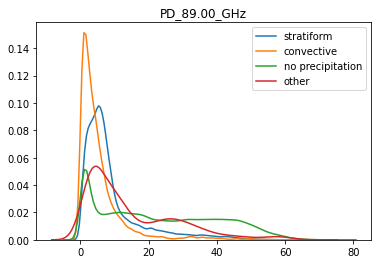

In [18]:
i = 3
plot_pd_per_pflag(pd_freqs[i], title=f'PD_{pd_freqs[i]}_GHz', plot_other=True, plot_no_precip=True, save=True)

Saved to /content/drive/My Drive/data/NASA_2020/plots/PD_166.0_GHz.png


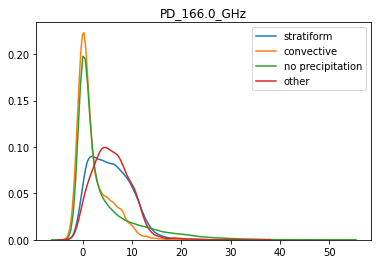

In [19]:
i = 4
plot_pd_per_pflag(pd_freqs[i], title=f'PD_{pd_freqs[i]}_GHz', plot_other=True, plot_no_precip=True, save=True)

# Squall Line Case

In [20]:
print(data['latc'].shape)
data['latc']

(44425, 221)


array([[  -99. ,   -99. ,   -99. , ...,   -99. ,   -99. ,   -99. ],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       ...,
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9]],
      dtype=float32)

In [21]:
print(data['lonc'].shape)
data['lonc']

(44425, 221)


array([[  -99. ,   -99. ,   -99. , ...,   -99. ,   -99. ,   -99. ],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       ...,
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9]],
      dtype=float32)

In [22]:
'''
lat boundary: [-2.1, -5.0] ?? --> maybe [2.1, 5.0]
lon boundary: [14.2, 18.0]
'''
def get_heatmap_points(lat_bounds, lon_bounds, df, epsilon=0):
  lat = []
  lon = []
  counts = []
  counter = 0
  for idx, x in np.ndenumerate(df):
    if (lat_bounds[0] - epsilon <= data['latc'][idx] <= lat_bounds[1] + epsilon) and (lon_bounds[0] - epsilon <= data['lonc'][idx] <= lon_bounds[1] + epsilon):
      lat.append(data['latc'][idx])
      lon.append(data['lonc'][idx])
      counts.append(x)
      counter += 1
  print(counter)
  return lat, lon, counts

In [23]:
lat, lon, counts = get_heatmap_points([-5.0, -2.1], [14.2, 18.0], PD['166.0'])

2654


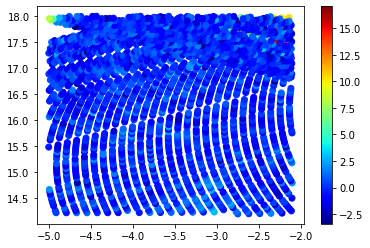

In [24]:
plt.scatter(lat, lon, c=counts, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.show()

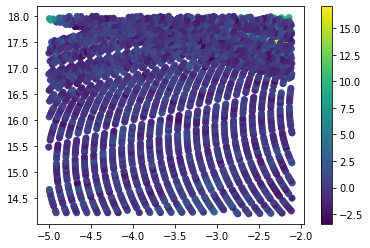

In [25]:
plt.scatter(lat, lon, c=counts)
plt.colorbar()
plt.show()

## Distribution of heatmap elements

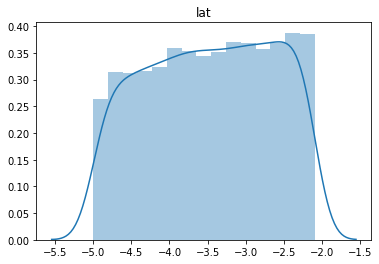

In [26]:
sns.distplot(lat)
plt.title("lat")
plt.show()

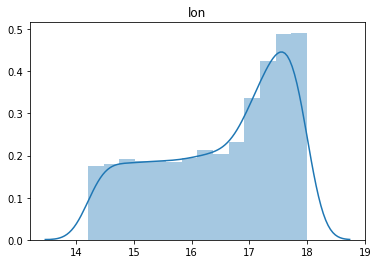

In [27]:
sns.distplot(lon)
plt.title("lon")
plt.show()

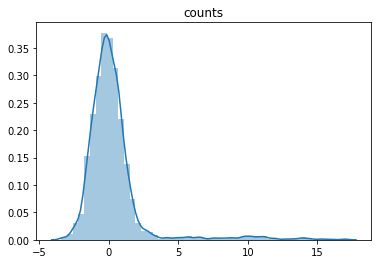

In [28]:
sns.distplot(counts)
plt.title("counts")
plt.show()